In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as sstat
from mpmath import mp
import math
import random
from scipy.stats import multivariate_normal
from sklearn import preprocessing as p

psd = pd.DataFrame
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

In [ ]:
def prior_unif():
  return tfd.Uniform(0,10)

In [ ]:
def prior_out(theta):
  a= theta[0]
  b= theta[1]
  g= theta[2]
  k= theta[3]
  a_prior = tfd.Uniform(0,10).prob(a)
  b_prior = tfd.Uniform(0,10).prob(b)
  g_prior = tfd.Uniform(0,10).prob(g)
  k_prior = tfd.Uniform(0,10).prob(k)
  return  a_prior *b_prior * g_prior*  k_prior 

In [ ]:
def my_kernel(u):
  return 1/(np.sqrt(2*math.pi))*np.exp(-1/2*u**2)

In [ ]:
def K_h(u,h):
  return my_kernel(u/h)/h

In [ ]:
def S2(y):
  quantiles= np.zeros(9)
  for i in range(9):
      quantiles[i]= np.quantile(y,0.1+0.1*i)       #quantili 0,1 0,2 0,3 0,4 0,5 0,6 0,7 0,8 0,9
  return quantiles

In [ ]:
def S1(y):
  return np.mean(y)

In [ ]:
from scipy.spatial import distance

def distance(s_old, s_obs):
   return np.linalg.norm(s_old-s_obs)
   # return distance.mahalanobis(s_old, s_obs, iv)

      

In [ ]:
def quantile_fun(theta,z):
    a= theta[0]
    b= theta[1]
    g= theta[2]
    k= theta[3]
    y = a+b*(1+0.8*(1-np.exp(-g*z))/(1+np.exp(-g*z)))*((1+z**2)**k)*z
    return y

In [ ]:
def quantile_fun_param(a,b,g,k,z):
    y = a+b*(1+0.8*(1-np.exp(-g*z))/(1+np.exp(-g*z)))*((1+z**2)**k)*z
    return y

In [ ]:
##MAXIMAL COUPLING OF THETA
def maximal_coupling(x,y):
      current_x = x
      current_y = y  
      const=0.1
      proposed_x = current_x  + np.random.multivariate_normal(np.zeros(4),const*np.identity(4))
      pX = sstat.multivariate_normal.pdf(proposed_x,current_x,np.identity(4))
      w = tfd.Uniform(0,1).sample()*pX
      qX = sstat.multivariate_normal.pdf(proposed_x,current_y,np.identity(4))
      #print('w',w,'qX',qX,'x',current_x,'y', current_y)
      if w < qX:
          x_new = proposed_x
          y_new = proposed_x
       
      else:
          t = True
          while t == True:
                proposed_y = current_y   + np.random.multivariate_normal(np.zeros(4),const*np.identity(4))
                qY =  sstat.multivariate_normal.pdf(proposed_y,current_y,np.identity(4)) 
                w =  tfd.Uniform(0,1).sample()*qY
                pY =sstat.multivariate_normal.pdf(proposed_y,current_x,np.identity(4))
                if w > pY :
                  t = False
          x_new = proposed_x
          y_new = proposed_y  


      return [x_new, y_new]

In [ ]:
def prob(H,s_obs,s_current,theta_current,s_i,theta_i):   #s[i,],a[i]
  NUM = (K_h(distance(np.array(s_current), np.array(s_obs)),H)*prior_out(theta_current))
  DEN = (K_h(distance(np.array(s_i),np.array(s_obs)),H)* prior_out(theta_i))
  return NUM/DEN    

In [ ]:
np.array([1,1,0.1,1])

In [ ]:
def abc_coupling_gandk(N, S, y_obs,h):
##INITIALIZATION:
    s_obs = S(y_obs)
    s1 = np.zeros((N+1,9))
    s2 = np.zeros((N+1,9))
    y1 = np.zeros(n)
    y2 = np.zeros(n)
    y1_current = np.zeros(n)
    y2_current = np.zeros(n)
    theta1=np.zeros((N+1,4))
    theta2=np.zeros((N+1,4))
    rate1=0
    rate2=0
    a1_0 =prior_unif().sample(1)
    b1_0 =prior_unif().sample(1)
    g1_0 =prior_unif().sample(1)
    k1_0 =prior_unif().sample(1)
    a2_0 =prior_unif().sample(1)
    b2_0 =prior_unif().sample(1)
    g2_0 =prior_unif().sample(1)
    k2_0 =prior_unif().sample(1)

# STARTING POINT:
    for i in range(n):
      z = tfd.Normal(0,1).sample() 
      y1[i]=quantile_fun_param(a1_0,b1_0,g1_0,k1_0,z)
    s1_0 = S(y1)

    for i in range(n):
      z = tfd.Normal(0,1).sample() 
      y2[i]=quantile_fun_param(a2_0,b2_0,g2_0,k2_0,z)
    s2_0 = S(y2)
   
    H=h
    #while K_h(mahal(np.array(s_0),np.array(s_obs)),H)<=0:
    while K_h(distance(np.array(s1_0),np.array(s_obs)),H)<=0:    
        a1_0 =prior_unif().sample(1)
        b1_0 =prior_unif().sample(1)
        g1_0 =prior_unif().sample(1)
        k1_0 =prior_unif().sample(1)
        for j in range(n):
          z = tfd.Normal(0,1).sample()
          y1[j]=quantile_fun_param(a1_0,b1_0,g1_0,k1_0,z)
        s1_0 = S(y1)
   
    theta1[0,:]=[a1_0,b1_0,g1_0,k1_0]

    while K_h(distance(np.array(s2_0),np.array(s_obs)),H)<=0:    
        a2_0 =prior_unif().sample(1)
        b2_0 =prior_unif().sample(1)
        g2_0 =prior_unif().sample(1)
        k2_0 =prior_unif().sample(1)
        for j in range(n):
          z = tfd.Normal(0,1).sample()
          y2[j]=quantile_fun_param(a2_0,b2_0,g2_0,k2_0,z)
        s2_0 = S(y2)
   
    theta2[0,:]=[a2_0,b2_0,g2_0,k2_0]
    
# ACTUAL IMPLEMENTATION
    for i in range(N):
        
        theta1_current,theta2_current = maximal_coupling(theta1[i,],theta2[i,])
           
        for j in range(n):
          z = tfd.Normal(0,1).sample() 
          y1_current[j] = quantile_fun(theta1_current,z)
          y2_current[j] = quantile_fun(theta2_current,z)
        s1_current = S(y1_current)
        s2_current = S(y2_current)

       
        #den_num=tfd.Normal(theta_muold,1).prob(theta_mucurrent)*tfd.Normal(theta_tauold,1).prob(theta_taucurrent)
        #den_den=tfd.Normal(theta_mucurrent,1).prob(theta_muold)*tfd.Normal(theta_taucurrent,1).prob(theta_tauold)
        
        prob1 = prob(H,s_obs,s1_current,theta1_current,s1[i,],theta1[i,])   #s[i,],a[i]unif().prob(a[i]))
        prob2 = prob(H,s_obs,s2_current,theta2_current,s2[i,],theta2[i,])

        acc_prob1 = min([1.,prob1])
        acc_prob2 = min([1.,prob2])
      
        u = tfd.Uniform(0,1).sample()
        if u < acc_prob1:
              theta1[i+1,] = theta1_current
              s1[i+1,] = s1_current
              rate1+=1
        else: 
              theta1[i+1,] = theta1[i,]
              s1[i+1,] = s1[i,]

        if u < acc_prob2:
              theta2[i+1,] = theta2_current
              s2[i+1,] = s2_current
              rate2+=1
        else: 
              theta2[i+1,]=theta2[i,]
              s2[i+1,] = s2[i,]

        
    return theta1,theta2, rate1, rate2

In [ ]:
aobs = 3
bobs = 1
gobs = 2
kobs = 0.5
n = 100
h = 0.6
y_obs = np.zeros(n)
for i in range(n):
  z = tfd.Normal(0,1).sample() 
  y_obs[i] = quantile_fun_param(aobs,bobs,gobs,kobs,z)

In [ ]:
theta1_post,theta2_post,acc1_all,acc2_all = abc_coupling_gandk(1000, S2, y_obs, 0.6)  

In [ ]:
np.mean(theta1_post[50:,0])

2.8814800350650938

In [ ]:
np.mean(theta2_post[:,0])

2.8134465666306694

In [ ]:
np.mean(theta1_post[:,1])

0.9447723809997056

In [ ]:
np.mean(theta2_post[:,1])

1.2062380842871685

In [ ]:
np.mean(theta1_post[:,2])

7.3773838445475795

In [ ]:
np.mean(theta2_post[:,2])

7.21810246533565

In [ ]:
np.mean(theta1_post[:,3])

0.5097174986061356

In [ ]:
np.mean(theta2_post[:,3])

0.24475643005029038

In [ ]:
acc1_all

193

In [ ]:
acc2_all

189

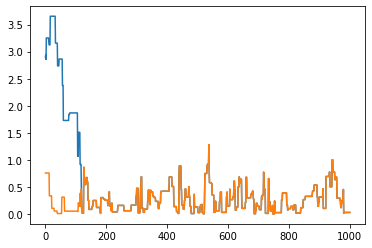

In [ ]:
plt.plot(theta1_post[:,3])
plt.plot(theta2_post[:,3])

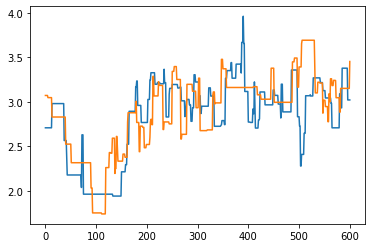

In [ ]:
k_post = []
for i in range(len(k1_post[:,0])):
  k_post.append([k1_post[i,0],k2_post[i,0]])
plt.plot(k_post)

In [ ]:
k1_post[:10,1]

array([3.12727356, 3.12727356, 3.12727356, 3.12727356, 3.12727356,
       3.12727356, 2.01927777, 0.88986428, 0.88986428, 0.90266426])

In [ ]:
k2_post[:10,1]

array([2.0730176, 0.940269 , 0.940269 , 0.940269 , 0.940269 , 0.940269 ,
       0.940269 , 0.940269 , 0.940269 , 0.940269 ])